### Pre-requisites

- Download the data: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Download the word vectors: http://nlp.stanford.edu/data/glove.6B.zip

In [74]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding

In [2]:
# Configurations
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

#### Load pre-trained word vectors

In [3]:
print('Loading word vectors....')
word2vec = {}

with open(os.path.join('Embeddings/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
     # The file contains just a space-separated text file in the format:
     # word vec[0] vec[1] vec[2] ...
    for line in f:
        # splits at spaces
        values = line.split()
        word = values[0]
        #np.asarray Converts the input to an array.
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors....
Found 400000 word vectors.


### Prepare training data

In [42]:
print('Loading comments')

train = pd.read_csv('data/toxic_comment/train.csv', header = 0)
train.head()
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#possible_labels = train.columns.values[2:]
targets = train[possible_labels].values

Loading comments


394.0732213246768 590.7202819048919 5000


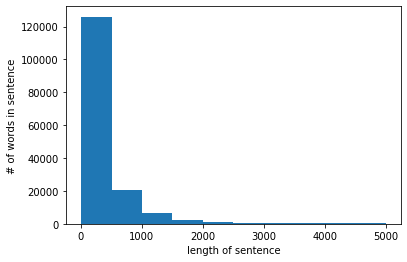

In [67]:
# The length of the comments varies a lot.
lengths = train.comment_text.str.len()
print(lengths.mean(), lengths.std(), lengths.max())
plt.hist(lengths)
plt.xlabel('length of sentence')
plt.ylabel('# of words in sentence')
plt.show()

### Convert the sentences (string) into integers

In [6]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
#print('sequences:', sequences); exit()

Max sequence length: 1400
Min sequence length: 0
median sequence length: 35


In [22]:
print('Max sequence length:', max(len(s) for s in sequences))
print('Min sequence length:', min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print('median sequence length:', s[len(s)//2])

Max sequence length: 1400
Min sequence length: 0
median sequence length: 35


### Word to integer mapping

In [23]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


### Pad Sequences

In [27]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data:', data.shape)

Shape of data: (159571, 100)


### Prepare Embedding matrix

In [37]:
print('Filling Pre-trained embeddings')
num_words = min(MAX_VOCAB_SIZE, len(word2vec)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will all be zero
            embedding_matrix[i] = embedding_vector

Filling Pre-trained embeddings


### Embedding layer

In [38]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

W0912 10:12:02.632814 140717174748992 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



### Build CNN model

In [84]:
print('Building model:')

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])
model.summary()

Building model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 8, 128)            49280

### Training Model

In [86]:
history = model.fit(data, targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 58s 451us/step - loss: 0.0735 - acc: 0.9758 - val_loss: 0.0944 - val_acc: 0.9711
Epoch 2/10
127656/127656 [==============================] - 60s 471us/step - loss: 0.0663 - acc: 0.9776 - val_loss: 0.0702 - val_acc: 0.9768
Epoch 3/10
127656/127656 [==============================] - 58s 455us/step - loss: 0.0623 - acc: 0.9786 - val_loss: 0.0686 - val_acc: 0.9774
Epoch 4/10
127656/127656 [==============================] - 56s 438us/step - loss: 0.0596 - acc: 0.9791 - val_loss: 0.0974 - val_acc: 0.9742
Epoch 5/10
127656/127656 [==============================] - 59s 460us/step - loss: 0.0576 - acc: 0.9799 - val_loss: 0.0772 - val_acc: 0.9746
Epoch 6/10
127656/127656 [==============================] - 58s 455us/step - loss: 0.0561 - acc: 0.9802 - val_loss: 0.0912 - val_acc: 0.9751
Epoch 7/10
127656/127656 [==============================] - 59s 462us/step - loss: 0.0553 - acc: 0.9805

### Visualize accuracy and loss curves

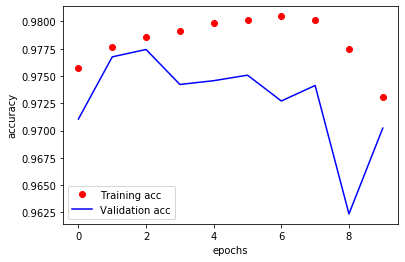

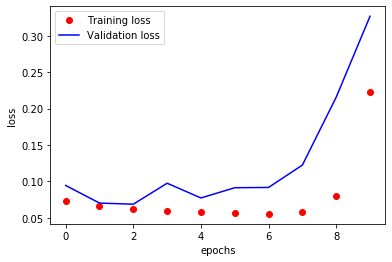

<Figure size 432x288 with 0 Axes>

In [99]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc_toxic_cnn.png')
plt.show()
plt.clf()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('static/loss_toxic_cnn.png')
plt.show()
plt.clf()